In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

In [3]:
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

In [4]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [5]:
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 2021
seed_everything(SEED)

In [6]:
path = 'data/'

In [7]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

# Oil moving average

data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.merge(data_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)

# Day of week

calendar['dofw'] = calendar.index.dayofweek

In [8]:
# Events

df_hev = pd.read_csv(path + 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)

df_hev['date'] = df_hev['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction
df_hev = df_hev.set_index('date').sort_index()

df_hev = df_hev[df_hev.locale == 'National'] # National level only for simplicity

df_hev = df_hev.groupby(df_hev.index).first() # Keep one event only

In [9]:
# Work days

calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False

calendar = calendar.merge(df_hev, how='left', left_index=True, right_index=True)

calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

In [10]:
df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

In [11]:
df_test = pd.read_csv(path + 'test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [12]:
sdate = '2017-04-01'
edate = '2017-08-15'

In [13]:
y = df_train.unstack(['store_nbr', 'family']).loc[sdate:edate]

fourier = CalendarFourier(freq='W', order=4)

dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

In [14]:

# Extentions

X['oil']  = calendar.loc[sdate:edate]['ma_oil'].values
X['dofw'] = calendar.loc[sdate:edate]['dofw'].values
X['wd']   = calendar.loc[sdate:edate]['wd'].values
X['type'] = calendar.loc[sdate:edate]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

model = Ridge(fit_intercept=True, solver='auto', alpha=0.4, random_state=SEED) # normalize=True,
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [15]:
# Results of the training stage

y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.251476
BABY CARE                     0.066430
BEAUTY                        0.257901
BEVERAGES                     0.191914
BOOKS                         0.026522
BREAD/BAKERY                  0.118938
CELEBRATION                   0.285361
CLEANING                      0.215332
DAIRY                         0.130165
DELI                          0.103083
EGGS                          0.137948
FROZEN FOODS                  0.156906
GROCERY I                     0.204414
GROCERY II                    0.341011
HARDWARE                      0.270799
HOME AND KITCHEN I            0.254058
HOME AND KITCHEN II           0.217400
HOME APPLIANCES               0.150015
HOME CARE                     0.116602
LADIESWEAR                    0.251027
LAWN AND GARDEN               0.205402
LINGERIE                      0.392642
LIQUOR,WINE,BEER              0.633928
MAGAZINES                     0.248351
MEATS                         0.113912
PERSONAL CARE     

In [16]:
# Clearly 'SCHOOL AND OFFICE SUPPLIES' needs special attention

<AxesSubplot: xlabel='date'>

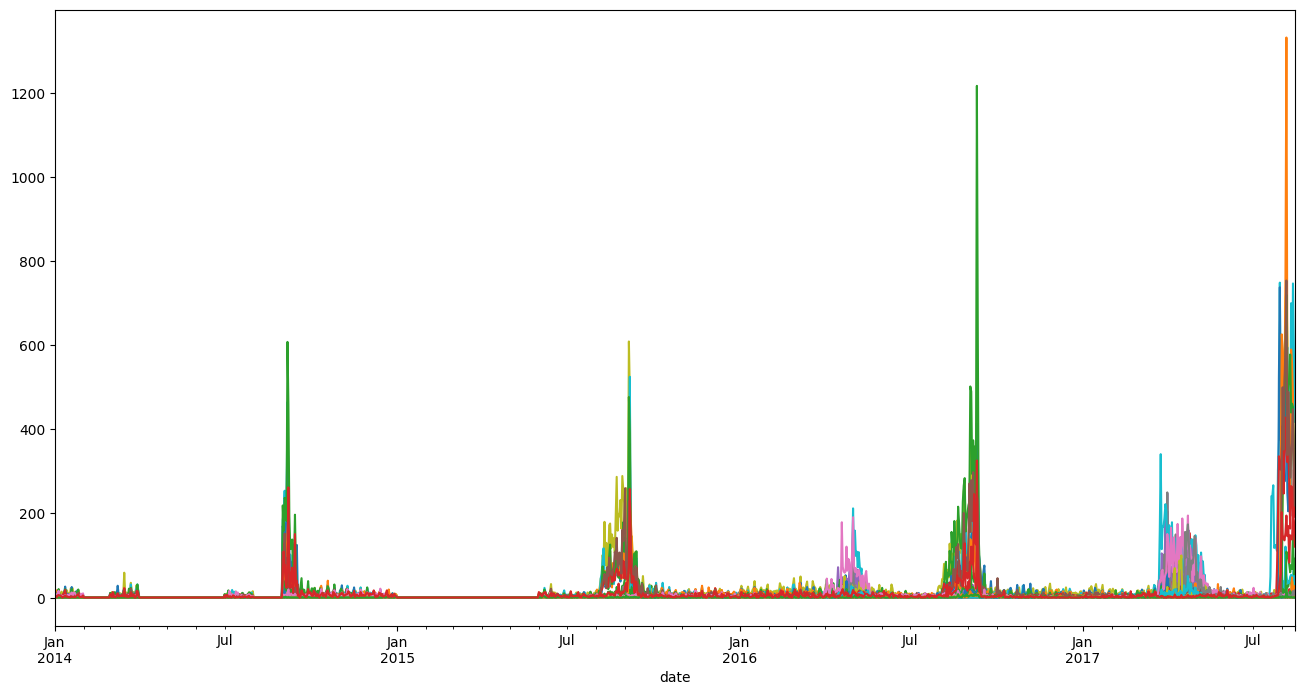

In [17]:
df_train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

In [17]:
# Looks like this group is a problem for linear regression
# Let's try to use RandomForest regressor instead

In [19]:
from joblib import Parallel, delayed
import warnings

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            r1 = ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)])
        else:
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, random_state=SEED) #, normalize=True

        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = [self._estimator_(X, y.iloc[:, i]) for i in range(y.shape[1])]
        
        return
    
    def predict(self, X):
        
        y_pred = [e.predict(X) for e in self.estimators_]
        
        return np.stack(y_pred, axis=1)

In [21]:
%%time

model = CustomRegressor(n_jobs=-1, verbose=0)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

CPU times: total: 3min 31s
Wall time: 13min 7s


In [22]:
# Results of the training stage with RF

y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.251843
BABY CARE                     0.066481
BEAUTY                        0.258316
BEVERAGES                     0.191974
BOOKS                         0.026568
BREAD/BAKERY                  0.118986
CELEBRATION                   0.285675
CLEANING                      0.215318
DAIRY                         0.130222
DELI                          0.103148
EGGS                          0.138037
FROZEN FOODS                  0.157259
GROCERY I                     0.204466
GROCERY II                    0.341408
HARDWARE                      0.271142
HOME AND KITCHEN I            0.254312
HOME AND KITCHEN II           0.217591
HOME APPLIANCES               0.150213
HOME CARE                     0.116671
LADIESWEAR                    0.251345
LAWN AND GARDEN               0.207535
LINGERIE                      0.393154
LIQUOR,WINE,BEER              0.634385
MAGAZINES                     0.248643
MEATS                         0.113927
PERSONAL CARE     

In [21]:
# Better, much better - but definitely very overfitted. The next step is to do something with this overfitting

In [25]:
dp.out_of_sample(steps=16)

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
2017-08-16,138.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2017-08-17,139.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2017-08-18,140.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2017-08-19,141.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
2017-08-20,142.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2017-08-21,143.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-08-22,144.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2017-08-23,145.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2017-08-24,146.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2017-08-25,147.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


In [26]:
# Test predictions

stest = '2017-08-16'
etest = '2017-08-31'

X_test = dp.out_of_sample(steps=16)

# Extentions

X_test['oil']  = calendar.loc[stest:etest]['ma_oil'].values
X_test['dofw'] = calendar.loc[stest:etest]['dofw'].values
X_test['wd']   = calendar.loc[stest:etest]['wd'].values

X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])

sales_pred[sales_pred < 0] = 0. # Sales should be >= 0

In [27]:
# Submission

df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values
df_sub.to_csv('submission.csv', index=True)